In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

### Confidence Intervals ###
We have developed a method for estimating a parameter by using random sampling and the bootstrap. Our method produces an interval of estimates, to account for chance variability in the random sample. By providing an interval of estimates instead of just one estimate, we give ourselves some wiggle room.

In the previous example we saw that our process of estimation produced a good interval about 95% of the time, a "good" interval being one that contains the parameter. We say that we are *95% confident* that the process results in a good interval. Our interval of estimates is called a *95% confidence interval* for the parameter, and 95% is called the *confidence level* of the interval.

The situation in the previous example was a bit unusual. Because we happened to know value of the parameter, we were able to check whether an interval was good or a dud, and this in turn helped us to see that our process of estimation captured the parameter about 95 out of every 100 times we used it.

But usually, data scientists don't know the value of the parameter. That is the reason they want to estimate it in the first place. In such situations, they provide an interval of estimates for the unknown parameter by using methods like the one we have developed. Because of statistical theory and demonstrations like the one we have seen, data scientists can be confident that their process of generating the interval results in a good interval a known percent of the time.

### Confidence Interval for a Population Median: Bootstrap Percentile Method ###

We will now use the bootstrap method to estimate an unknown population median. The data come from a sample of newborns in a large hospital system; we will treat it as if it were a simple random sample though the sampling was done in multiple stages. [Stat Labs](https://www.stat.berkeley.edu/~statlabs/) by Deborah Nolan and Terry Speed has details about a larger dataset from which this set is drawn. 

The table `baby` contains the following variables for mother-baby pairs: the baby's birth weight in ounces, the number of gestational days, the mother's age in completed years, the mother's height in inches, pregnancy weight in pounds, and whether or not the mother smoked during pregnancy.

In [2]:
baby = Table.read_table('baby.csv')

In [3]:
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


Birth weight is an important factor in the health of a newborn infant – smaller babies tend to need more medical care in their first days than larger newborns. It is therefore helpful to have an estimate of birth weight before the baby is born. One way to do this is to examine the relationship between birth weight and the number of gestational days. 

A simple measure of this relationship is the ratio of birth weight to the number of gestational days. The table `ratios` contains the first two columns of `baby`, as well as a column of the ratios. The first entry in that column was calcualted as follows:

$$
\frac{120~\mbox{ounces}}{284~\mbox{days}} ~\approx ~ 0.4225~ \mbox{ounces per day}
$$

In [4]:
ratios = baby.select('Birth Weight', 'Gestational Days').with_column(
    'Ratio BW/GD', baby.column('Birth Weight')/baby.column('Gestational Days')
)

In [5]:
ratios

Birth Weight,Gestational Days,Ratio BW/GD
120,284,0.422535
113,282,0.400709
128,279,0.458781
108,282,0.382979
136,286,0.475524
138,244,0.565574
132,245,0.538776
120,289,0.415225
143,299,0.478261
140,351,0.39886


Here is a histogram of the ratios.

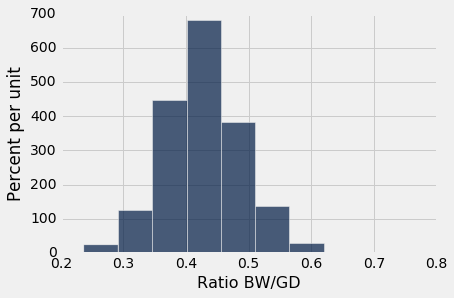

In [6]:
ratios.select('Ratio BW/GD').hist()

At first glance the histogram looks quite symmetric, with the density at its maximum over the interval 4 ounces per day to 4.5 ounces per day. But a closer look reveals that some of the ratios were quite large by comparison. The maximum value of the ratios was just over 0.78 ounces per day, almost double the typical value.

In [7]:
ratios.sort('Ratio BW/GD', descending=True).take(0)

Birth Weight,Gestational Days,Ratio BW/GD
116,148,0.783784


The median gives a sense of the typical ratio because it is unaffected by the very large or very small ratios. The median ratio in the sample is about 0.429 ounces per day.

In [8]:
np.median(ratios.column(2))

0.42907801418439717

But what was the median in the population? We don't know, so we will estimate it. 

Our method will be exactly the same as in the previous section. We will bootstrap the sample 5,000 times resulting in 5,000 estimates of the median. Our 95% confidence interval will be the "middle 95%" of all of our estimates.

Recall the function `bootstrap_median` defined in the previous section. We will call this function and construct a 95% confidence interval for the median ratio in the population. Remember that the table `ratios` contains the relevant data from our original sample.

In [9]:
def bootstrap_median(original_sample, label, replications):
    
    """Returns an array of bootstrapped sample medians:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    
    just_one_column = original_sample.select(label)
    medians = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resampled_median = percentile(50, bootstrap_sample.column(0))
        medians = np.append(medians, resampled_median)
        
    return medians

In [10]:
# Generate the medians from 5000 bootstrap samples
bstrap_medians = bootstrap_median(ratios, 'Ratio BW/GD', 5000)

In [11]:
# Get the endpoints of the 95% confidence interval
left = percentile(2.5, bstrap_medians)
right = percentile(97.5, bstrap_medians)

make_array(left, right)

array([ 0.42545455,  0.43262411])

The 95% confidence interval goes form about 0.425 ounces per day to about 0.433 ounces per day. We are estimating the the median "birth weight to gestational days" ratio in the population is somewhere in the interval 0.425 ounces per day to 0.433 ounces per day.

The estimate of 0.429 based on the original sample happens to be exactly half-way in between the two ends of the interval, though that need not be true in general.

To visualize our results, let us draw the empirical histogram of our bootstrapped medians and place the confidence interval on the horizontal axis.

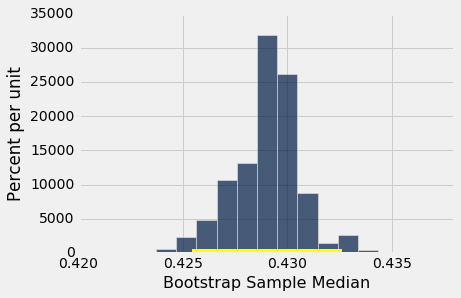

In [12]:
resampled_medians = Table().with_column(
    'Bootstrap Sample Median', bstrap_medians
)
resampled_medians.hist(bins=15)
plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);

This histogram and interval resembles those we drew in the previous section, with one big difference – there is no red dot showing where the parameter is. We don't know where that dot should be, or whether it is even in the interval.

We just have an interval of estimates. It is a 95% confidence interval of estimates, because the process that generates it produces a good interval about 95% of the time. That certainly beats guessing at random!

Keep in mind that this interval is an approximate 95% confidence interval. There are many approximations involved in its computation. The approximation is not bad, but it is not exact.

### Confidence Interval for a Population Mean: Bootstrap Percentile Method ###
What we have done for medians can be done for means as well. Suppose we want to estimate the average age of the mothers in the population. A natural estimate is the average age of the mothers in the sample. Here is the distribution of their ages, and their average age which was about 27.2 years.

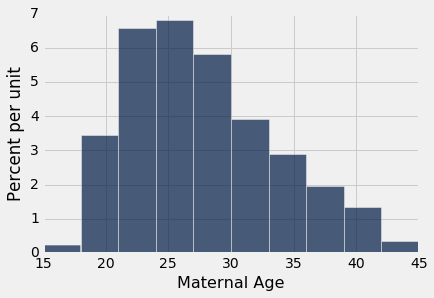

In [13]:
baby.select('Maternal Age').hist()

In [14]:
np.mean(baby.column('Maternal Age'))

27.228279386712096

What was the average age of the mothers in the population? We don't know the value of this parameter.

Let's estimate the unknown parameter by the bootstrap method. To do this, we will edit the code for `bootstrap_median` to instead define the function `bootstrap_mean`. The code is the same except that the statistics are means instead of medians, and are collected in an array called `means` instead of `medians`

In [15]:
def bootstrap_mean(original_sample, label, replications):
    
    """Returns an array of bootstrapped sample means:
    original_sample: table containing the original sample
    label: label of column containing the variable
    replications: number of bootstrap samples
    """
    
    just_one_column = original_sample.select(label)
    means = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resampled_mean = np.mean(bootstrap_sample.column(0))
        means = np.append(means, resampled_mean)
        
    return means

In [16]:
# Generate the means from 5000 bootstrap samples
bstrap_means = bootstrap_mean(baby, 'Maternal Age', 5000)

# Get the endpoints of the 95% confidence interval
left = percentile(2.5, bstrap_means)
right = percentile(97.5, bstrap_means)

make_array(left, right)

array([ 26.89778535,  27.55962521])

The 95% confidence interval goes from about 26.9 years to about 27.6 years. That is, we are estimating that the average age of the mothers in the population is somewhere in the interval 26.9 years to 27.6 years. 

Notice how close the two ends are to the average of about 27.2 years in the original sample. The sample size is very large – 1,174 mothers – and so the sample averages don't vary much. We will explore this observation further in the next chapter.

The empirical histogram of the 5,000 bootstrapped means is shown below, along with the 95% confidence interval for the population mean.

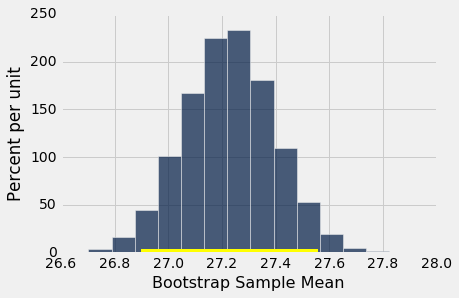

In [17]:
resampled_means = Table().with_column(
    'Bootstrap Sample Mean', bstrap_means
)
resampled_means.hist(bins=15)
plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);

Once again, the average of the original sample (27.23 years) is close to the center of the interval. That's not very surprising, because each bootstrapped sample is drawn from that same original sample. The averages of the bootstrapped samples are about symmetrically distributed on either side of the average of the sample from which they were drawn.

Notice also that the empirical histogram of the resampled means has roughly a symmetric bell shape, even though the histogram of the sampled ages was not symmetric at all:

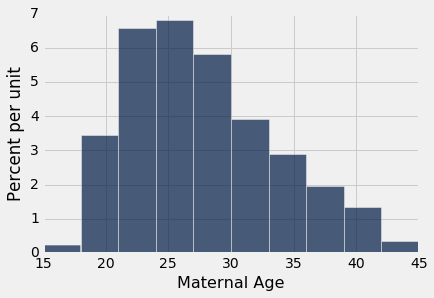

In [18]:
baby.select('Maternal Age').hist()

This is a consequence of the Central Limit Theorem of probability and statistics. In later sections, we will see what the theorem says.

### An 80% Confidence Interval ###
You can use the bootstrapped sample means to construct an interval of any level of confidence. For example, to construct an 80% confidence interval for the mean age in the population, you would take the "middle 80%" of the resampled means. So you would want 10% of the disribution in each of the two tails, and hence the endpoints would be the 10th and 90th percentiles of the resampled means.

In [19]:
left_80 = percentile(10, bstrap_means)
right_80 = percentile(90, bstrap_means)
make_array(left_80, right_80)

array([ 27.01192504,  27.439523  ])

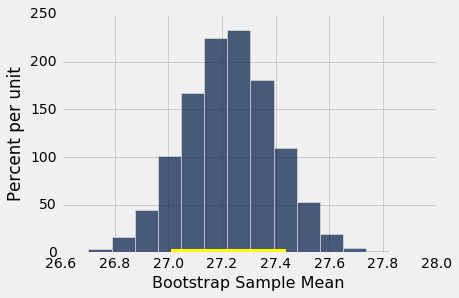

In [20]:
resampled_means.hist(bins=15)
plots.plot(make_array(left_80, right_80), make_array(0, 0), color='yellow', lw=8);

This 80% confidence interval is much shorter than the 95% confidence interval. It only goes from about 27.0 years to about 27.4 years. While that's a tight set of estimates, you know that this process only produces a good interval about 80% of the time. 

The earlier process produced a wider interval but we had more confidence in the process that generated it.

To get a narrow confidence interval at a high level of confidence, you'll have to start with a larger sample. We'll see why in the next chapter.

### Confidence Interval for a Population Proportion: Bootstrap Percentile Method ###
In the sample, 39% of the mothers smoked during pregnancy.

In [23]:
baby.where('Maternal Smoker', are.equal_to(True)).num_rows/baby.num_rows

0.3909710391822828

For what follows is useful to observe that this proportion can also be calculated by an array operation:

In [24]:
smoking = baby.column('Maternal Smoker')
np.count_nonzero(smoking)/len(smoking)

0.3909710391822828

What percent of mothers in the population smoked during pregnancy? This is an unknown parameter which we can estimate by a bootstrap confidence interval. The steps in the process are analogous to those we took to estimate the population mean and median.

We will start by defining a function `bootstrap_proportion` that returns an array of bootstrapped sampled proportions. Once again, we will achieve this by editing our definition of `bootstrap_median`. The only change in computation is in replacing the median of the resample by the proportion of smokers in it. The code assumes that the column of data consists of Boolean values. The other changes are only to the names of arrays, to help us read and understand our code.

In [31]:
def bootstrap_proportion(original_sample, label, replications):
    
    """Returns an array of bootstrapped sample proportions:
    original_sample: table containing the original sample
    label: label of column containing the Boolean variable
    replications: number of bootstrap samples
    """
    
    just_one_column = original_sample.select(label)
    proportions = make_array()
    for i in np.arange(replications):
        bootstrap_sample = just_one_column.sample()
        resample_array = bootstrap_sample.column(0)
        resampled_proportion = np.count_nonzero(resample_array)/len(resample_array)
        proportions = np.append(proportions, resampled_proportion)
        
    return proportions

Let us use `bootstrap_proportion` to construct an approximate 95% confidence interval for the percent of smokers among the mothers in the population. The code is analogous to the corresponding code for the mean and median.

In [32]:
# Generate the proportions from 5000 bootstrap samples
bstrap_props = bootstrap_proportion(baby, 'Maternal Smoker', 5000)

# Get the endpoints of the 95% confidence interval
left = percentile(2.5, bstrap_props)
right = percentile(97.5, bstrap_props)

make_array(left, right)

array([ 0.36286201,  0.41908007])

The confidence interval goes from about 36% to about 42%. The original sample percent of 39% is very close to the center of the interval, as you can see below.

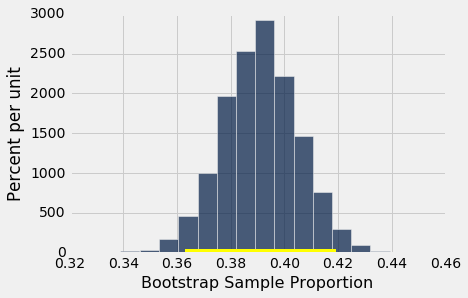

In [33]:
resampled_proportions = Table().with_column(
    'Bootstrap Sample Proportion', bstrap_props
)
resampled_proportions.hist(bins=15)
plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);

### Care in Using the Bootsrap ###
The bootstrap is an elegant and powerful method. Before using it, it is important to keep some points in mind.

- Start with a large random sample. If you don't, the method might not work. Its success is based on large random samples (and hence also resamples from the sample) resembling the population. The Law of Averages says that this is likely to be true provided the random sample is large.

- To approximate the probability distribution of a statistic, it is a good idea to replicate the resampling procedure as many times as possible. A few thousand replications will result in decent approximations to the distribution of sample median, especially if the distribution of the population has one peak and is not very asymmetric. We used 5,000 replications in our examples but would recommend 10,000 in general.

- The bootstrap percentile method works well for estimating the population median or mean based on a large random sample. However, it has limitations, as do all methods of estimation. For example, it is not expected to do well in the following situations.
    - The goal is to estimate the minimum or maximum value in the population, or a very low or very high percentile, or parameters that are greatly influenced by rare elements of the population.
    - The probability distribution of the statistic is not roughly bell shaped.
    - The original sample is very small, say less than 10 or 15.

